In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from glob import glob 

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html

import scipy 
from scipy import ndimage

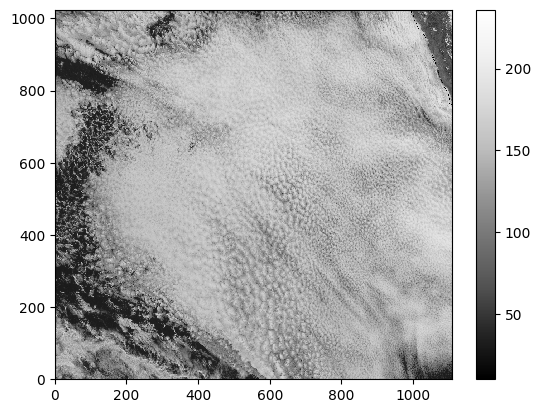

In [3]:
# Define the path to the directory containing the images
path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
# Use glob to find the images in the specified path
fnames = np.sort(glob(path + '*9_06*png'))
images = []

# Read the images and process them
for i, fname in enumerate(fnames):
    img = imageio.v2.imread(fname)
    red = np.flipud(img[:, 400:, 0])
    images.append(red)  # Just red channel, just 400:end in the x dir, flip y

# Plot the first processed image
plt.pcolormesh(images[0], cmap='Greys_r')
plt.colorbar()
plt.show()


In [4]:
# Get the dimensions of the image
height, width = red.shape[:2]

# Create 2D arrays of x and y
x = np.arange(width)
y = np.arange(height)

# Create a meshgrid of x and y
X, Y = np.meshgrid(x, y)


# Pixel size: nominal for MKS units to pixel units 
DX = 2000             # m, pixel size (nominal)

# Xm and Ym are Coordinates in meters, distances measured from central point of image
Xm = (X-X.mean())*DX
Ym = (Y-Y.mean())*DX 

-------------------

# Wave parameters for warping and modulating an image

"In one period, 7–9 October 2008, the waves modulated cloud-top-height by up to 400 m peak-to-trough, propagating perpendicular to the synoptic boundary layer flow with phase speed 15.3 m s−1, period ∼1 h and horizontal wavelength 55 km. The gravity waves were observed to be non-dispersive. “ from https://doi.org/10.1002/qj.1952

For a wave moving toward 45 degrees (northeast), define k and l as positive (sin and cos of nav angle). Let's take z = sin( k(x-ct) + l(y-ct) ) which is indeed moving NEward with time. Then u and v are both positive at z crests (sketch it). That means dx and dy are positve when time is 1/4 period later, or when 90deg of phase have been subtracted since t appears with a negative sign in the formula for phase (x-ct). 

In [5]:
# One wave packet 
cphase = 14            # m/s
wavelength = 150*1000. # meters
period = wavelength/cphase 
direction = 225       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude = 100      # meters, vertical displacement
PBLdepth = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k = 2*np.pi/wavelength * np.sin( (direction) *np.pi/180 )   
l = 2*np.pi/wavelength * np.cos( (direction) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x = -400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y = 400*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x  = 400*1000.  # meters
packet_width_y  = 300*1000.  # meters
Ampwindow = np.exp(-( ((Xm-packet_center_x)/packet_width_x)**2 + \
                      ((Ym-packet_center_y)/packet_width_y)**2 )) 
     
#plt.pcolormesh(Ampwindow); plt.colorbar()

In [6]:
# A second wave packet 
cphase2 = 20            # m/s
wavelength2 = 100*1000. # meters
period2 = wavelength2/cphase2 
direction2 = 140       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude2 = 50      # meters, vertical displacement
PBLdepth2 = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k2 = 2*np.pi/wavelength2 * np.sin( (direction2) *np.pi/180 )   
l2 = 2*np.pi/wavelength2 * np.cos( (direction2) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x2 = 400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y2 = 100*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x2  = 200*1000.  # meters
packet_width_y2  = 600*1000.  # meters
Ampwindow2 = np.exp(-( ((Xm-packet_center_x2)/packet_width_x2)**2 + \
                      ( (Ym-packet_center_y2)/packet_width_y2)**2 )) 
     

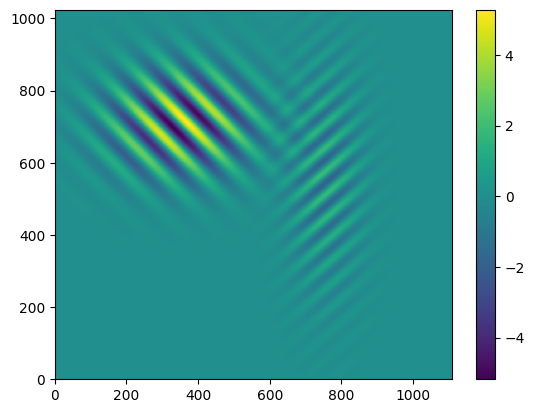

In [7]:
# Constants for this animation 
time_steps = 10            # Number of time steps 
time_resolution = 1800     # seconds, images are half an hour apart

# The resulting image arrays, for animation 
grid = np.zeros((height, width, time_steps))


# BUILD THE WARPED MODULATED IMAGES AT EACH TIME

for it in range(time_steps):
    t = it*time_resolution     # t is in seconds 

# dz measures vertical displacements: let's choose the sine function. Two packets 
    dz = zamplitude \
         * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) ) *Ampwindow 
    dz2 = zamplitude2 \
         * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) ) *Ampwindow2

# wave dx and dy are 90deg behind phase with dz, prop. to wavelength. 
# DIRECTION: For 45deg (wave going NE), k>0,l>0, dx>0,dy>0 (sketch it). 

    dxy = (zamplitude/PBLdepth)*wavelength \
          * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) -np.pi/2.) /DX
    dx = dxy * np.sin(direction *np.pi/180.) *Ampwindow # why /2? because it is too strong. Pixel units?? 
    dy = dxy * np.cos(direction *np.pi/180.) *Ampwindow

    dxy2= (zamplitude2/PBLdepth2)*wavelength2 \
          * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) -np.pi/2.) /DX
    dx2= dxy2* np.sin(direction2 *np.pi/180.) *Ampwindow2 
    dy2= dxy2* np.cos(direction2 *np.pi/180.) *Ampwindow2

# Warping by transporting pixels in original red image, wrapping (periodic) for now. SUBTRACT dy and dx in argument. 
    grid[:,:,it] = ndimage.map_coordinates(images[it],[Y-dy-dy2, X-dx-dx2])  

# Modulate (multiply) albedo by a wavy pattern (vertical displacements, 
#           make consistent with xmotion and ymotion arrays above) 
    grid[:,:,it] *= (1 + dz /PBLdepth  *5) 
    grid[:,:,it] *= (1 + dz2/PBLdepth2 *5) 

maxvalue = grid.max()
maxvalue

plt.pcolormesh(dy+dy2); plt.colorbar(); # pixels units -- surprising that 7 pixels make such a huge warp?

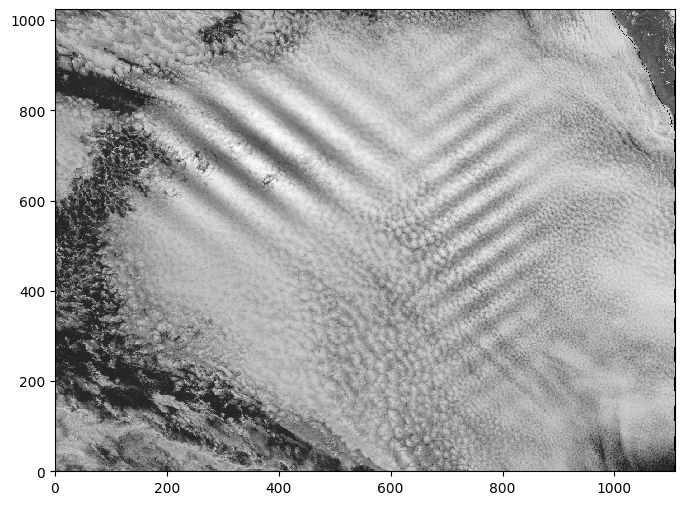

In [8]:
plt.figure(figsize=(8,6))
plt.pcolormesh(grid[:,:,0], cmap='Greys_r')

## Wavelet processing - Anisotropic wavelets

Shape of cwtmexh['cfs']: (32, 32, 1, 1, 2)


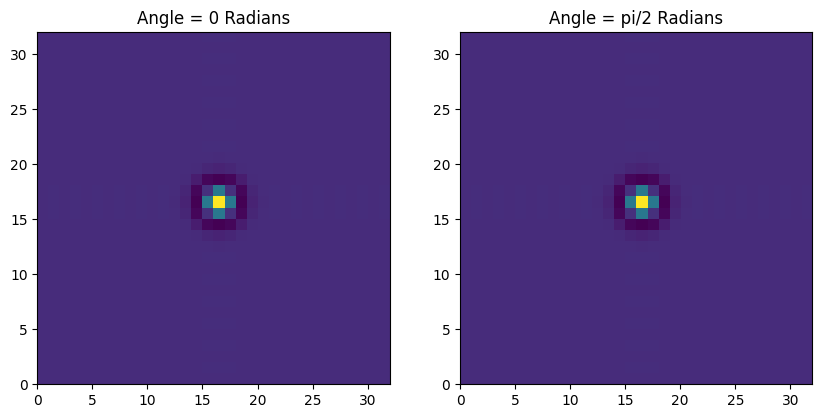

Shape of cwtmorl['cfs']: (64, 64, 1, 1, 2)


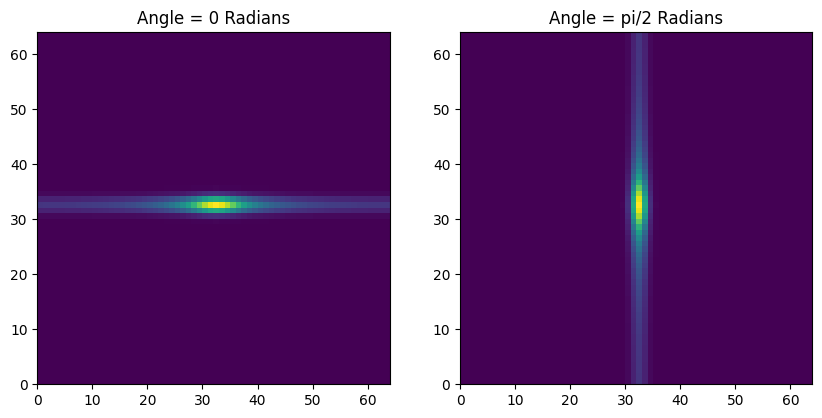

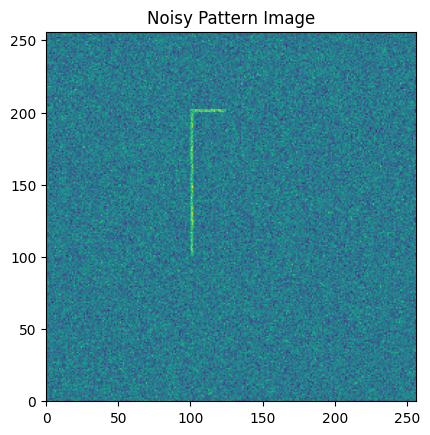

Shape of cwtmexh['cfs']: (256, 256, 1, 11)


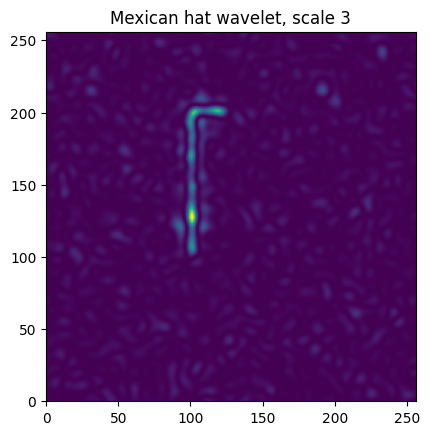

Shape of cwtmorl['cfs']: (256, 256, 1, 11, 2)


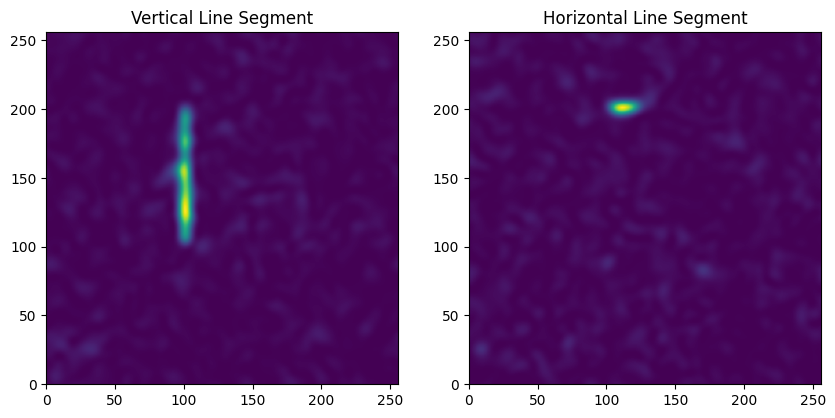

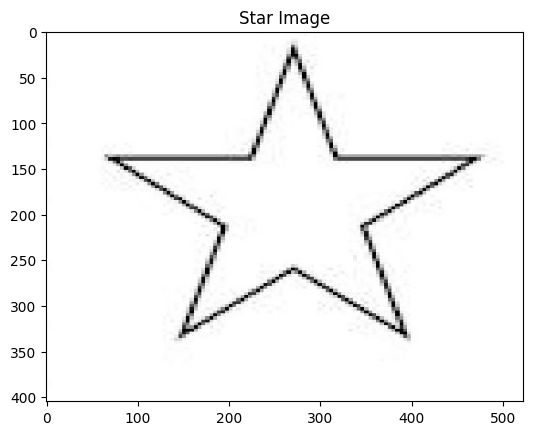

Shape of cwtout['cfs']: (405, 523, 3, 6)


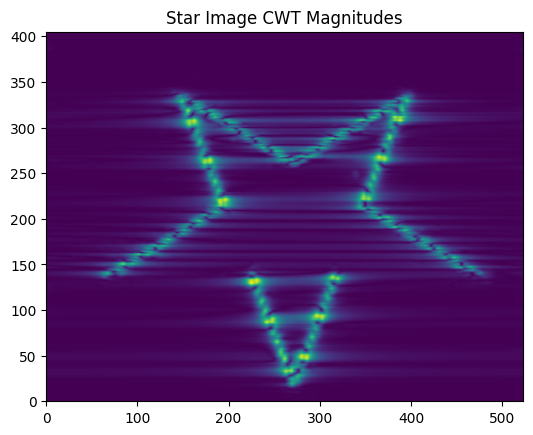

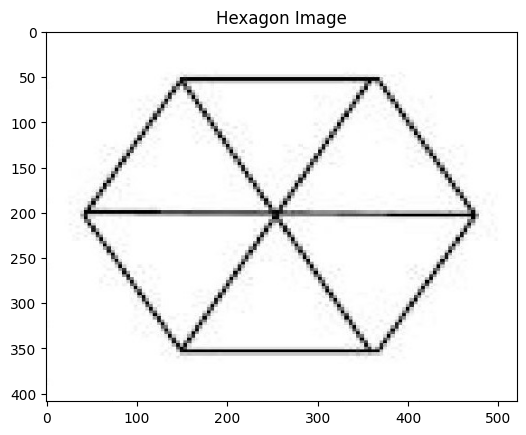

Shape of cwtCauchy['cfs']: (409, 521, 3, 1, 16)
Shape of cwtMarr['cfs']: (409, 521, 3, 1, 16)


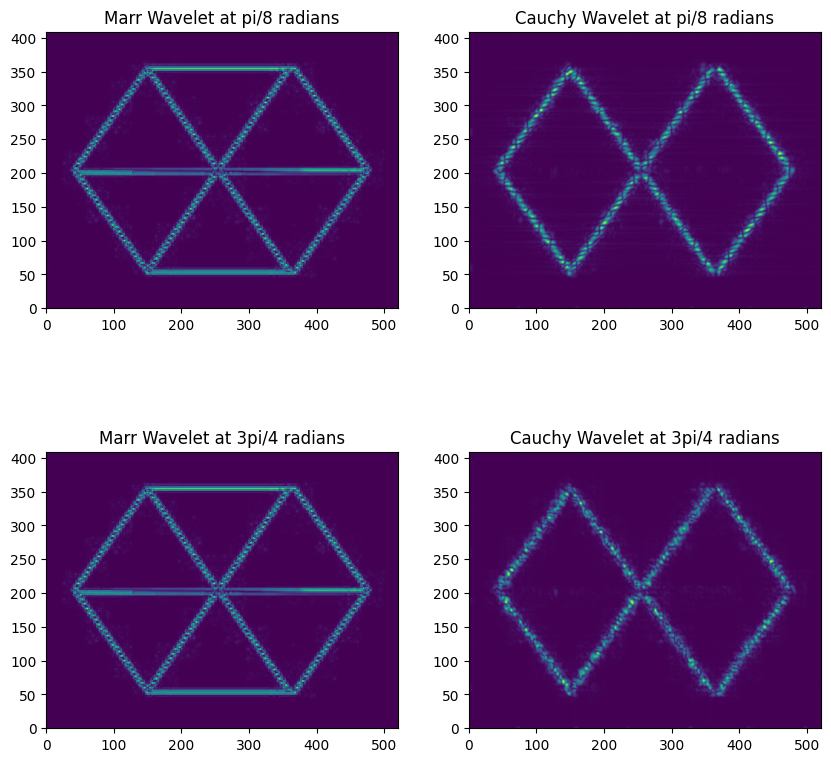

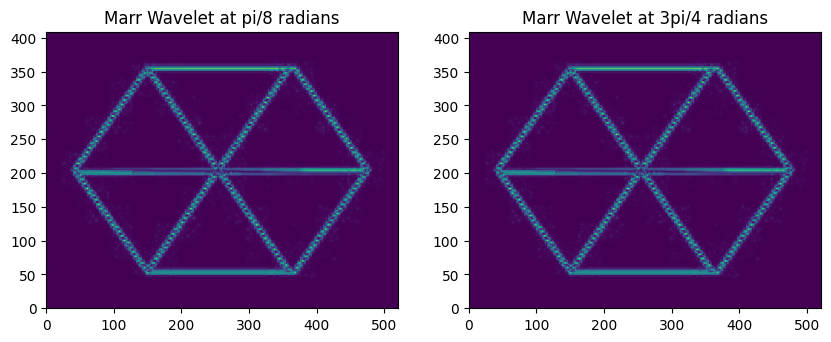

In [8]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Define a small image with a single pixel set to 1
Y = np.zeros((32, 32))
Y[16, 16] = 1
Y_mat = matlab.double(Y.tolist())

# Apply 2-D CWT using Mexican hat wavelet at angle 0 radians and pi/2 radians
angles = [0.0, np.pi/2.0]  # Ensure the angles are scalar doubles
angles_mat = matlab.double(angles)

cwtmexh = eng.cwtft2(Y_mat, 'wavelet', 'mexh', 'scales', 1.0, 'angles', angles_mat)
print(f"Shape of cwtmexh['cfs']: {np.array(cwtmexh['cfs']).shape}")
cfs = np.array(cwtmexh['cfs'])

# Adjusting the indexing based on the shape
cfs_0 = cfs[:,:,0,0,0]
cfs_pi_2 = cfs[:,:,0,0,1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cfs_0.real, extent=[0, 32, 0, 32], origin='lower')
axs[0].set_title('Angle = 0 Radians')
axs[1].imshow(cfs_pi_2.real, extent=[0, 32, 0, 32], origin='lower')
axs[1].set_title('Angle = pi/2 Radians')
plt.show()

# Define a larger image with a single pixel set to 1
Y = np.zeros((64, 64))
Y[32, 32] = 1
Y_mat = matlab.double(Y.tolist())

# Apply 2-D CWT using Morlet wavelet at angle 0 radians and pi/2 radians
cwtmorl = eng.cwtft2(Y_mat, 'wavelet', 'morl', 'scales', 1.0, 'angles', angles_mat)
print(f"Shape of cwtmorl['cfs']: {np.array(cwtmorl['cfs']).shape}")
cfs = np.array(cwtmorl['cfs'])

# Adjusting the indexing based on the shape
cfs_0 = cfs[:,:,0,0,0]
cfs_pi_2 = cfs[:,:,0,0,1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.abs(cfs_0), extent=[0, 64, 0, 64], origin='lower')
axs[0].set_title('Angle = 0 Radians')
axs[1].imshow(np.abs(cfs_pi_2), extent=[0, 64, 0, 64], origin='lower')
axs[1].set_title('Angle = pi/2 Radians')
plt.show()

# Create a noisy pattern image with line segments joined at 90-degree angle
X = np.zeros((256, 256))
X[100:200, 100:102] = 3
X[200:202, 100:125] = 3
X = X + np.random.randn(*X.shape)
X_mat = matlab.double(X.tolist())

plt.imshow(X, extent=[0, 256, 0, 256], origin='lower')
plt.title('Noisy Pattern Image')
plt.show()

# Apply 2-D CWT using Mexican hat wavelet, visualize scale 3
scales = list(np.arange(3, 8.5, 0.5))
scales_mat = matlab.double(scales)

cwtmexh = eng.cwtft2(X_mat, 'wavelet', 'mexh', 'scales', scales_mat)
print(f"Shape of cwtmexh['cfs']: {np.array(cwtmexh['cfs']).shape}")
cfs = np.array(cwtmexh['cfs'])

# Adjusting the indexing based on the shape
cfs_3 = cfs[:,:,0,3]

plt.imshow(np.abs(cfs_3)**2, extent=[0, 256, 0, 256], origin='lower')
plt.title('Mexican hat wavelet, scale 3')
plt.show()

# Apply 2-D CWT using Morlet wavelet to extract vertical and horizontal line segments
cwtmorl = eng.cwtft2(X_mat, 'wavelet', 'morl', 'scales', scales_mat, 'angles', angles_mat)
print(f"Shape of cwtmorl['cfs']: {np.array(cwtmorl['cfs']).shape}")
cfs = np.array(cwtmorl['cfs'])

# Adjusting the indexing based on the shape
cfs_vertical = cfs[:,:,0,4,0]
cfs_horizontal = cfs[:,:,0,4,1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.abs(cfs_vertical)**2, extent=[0, 256, 0, 256], origin='lower')
axs[0].set_title('Vertical Line Segment')
axs[1].imshow(np.abs(cfs_horizontal)**2, extent=[0, 256, 0, 256], origin='lower')
axs[1].set_title('Horizontal Line Segment')
plt.show()

# Load and display the star image
img = plt.imread("star.jpg")
img_mat = matlab.uint8(img.tolist())

plt.imshow(img)
plt.title('Star Image')
plt.show()

# Obtain 2-D CWT of the star image and visualize magnitudes at the finest scale
cwtout = eng.cwtft2(img_mat)
print(f"Shape of cwtout['cfs']: {np.array(cwtout['cfs']).shape}")
cfs = np.array(cwtout['cfs'])

# Adjusting the indexing based on the shape
# Assuming we want the first channel and the first scale
cfs_star = cfs[:,:,0,0]

plt.imshow(np.abs(cfs_star), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
plt.title('Star Image CWT Magnitudes')
plt.show()

# Load and view the hexagon image
img = plt.imread("hexagon.jpg")
img_mat = matlab.uint8(img.tolist())

plt.imshow(img)
plt.title('Hexagon Image')
plt.show()

# Obtain 2-D CWT of the hexagon image using Marr and Cauchy wavelets
cwtScales = matlab.double([1])
cwtAngles = matlab.double(list(np.arange(0, 2*np.pi, np.pi/8)))

cwtCauchy = eng.cwtft2(img_mat, 'wavelet', 'cauchy', 'scales', cwtScales, 'angles', cwtAngles)
cwtMarr = eng.cwtft2(img_mat, 'wavelet', 'marr', 'scales', cwtScales, 'angles', cwtAngles)

print(f"Shape of cwtCauchy['cfs']: {np.array(cwtCauchy['cfs']).shape}")
print(f"Shape of cwtMarr['cfs']: {np.array(cwtMarr['cfs']).shape}")
cfs_cauchy = np.array(cwtCauchy['cfs'])
cfs_marr = np.array(cwtMarr['cfs'])

angz = ["0", "pi/8", "pi/4", "3pi/8", "pi/2", "5pi/8", "3pi/4", "7pi/8", 
        "pi", "9pi/8", "5pi/4", "11pi/8", "3pi/2", "13pi/8", "7pi/4", "15pi/8"]

indexAngle1 = 1  # pi/8
indexAngle2 = 6  # 3pi/4

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, k in enumerate([indexAngle1, indexAngle2]):
    axs[i, 0].imshow(np.abs(cfs_marr[:,:,0,0,k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i, 0].set_title(f'Marr Wavelet at {angz[k]} radians')
    axs[i, 1].imshow(np.abs(cfs_cauchy[:,:,0,0,k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i, 1].set_title(f'Cauchy Wavelet at {angz[k]} radians')
plt.show()

# Visualize the 2-D CWT coefficient magnitudes using Marr wavelet at two angles, if available
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, k in enumerate([indexAngle1, indexAngle2]):
    axs[i].imshow(np.abs(cfs_marr[:,:,0,0,k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i].set_title(f'Marr Wavelet at {angz[k]} radians')
plt.show()

# Stop MATLAB engine
eng.quit()


## Exploring wavelets

#### Generate a wavelet for at a specific scale for fine-tuning

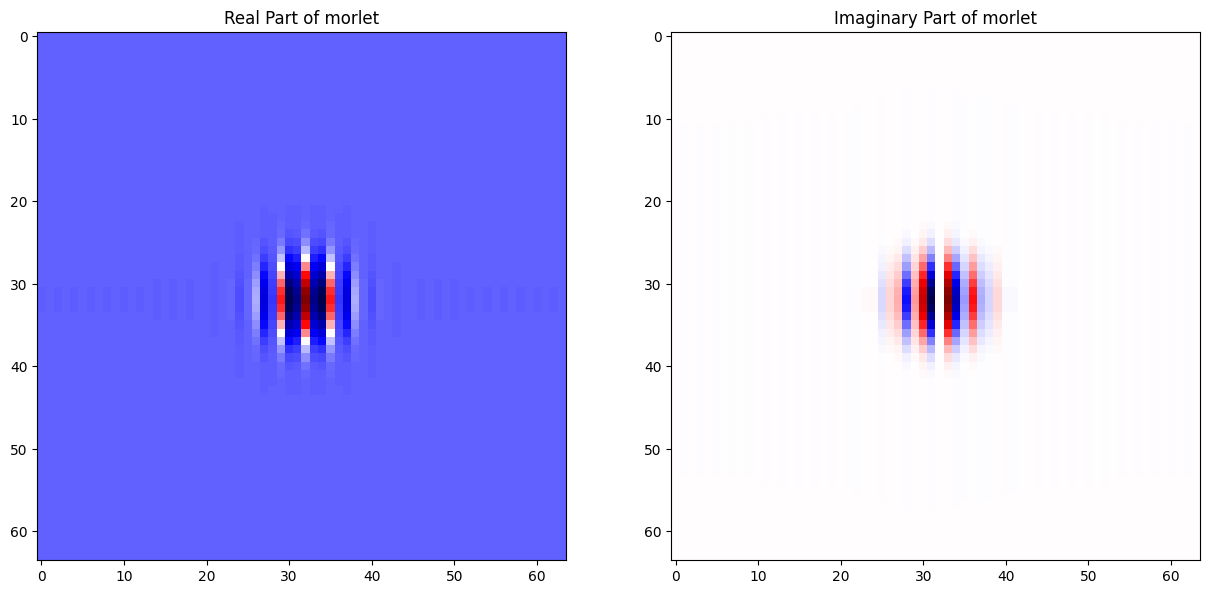

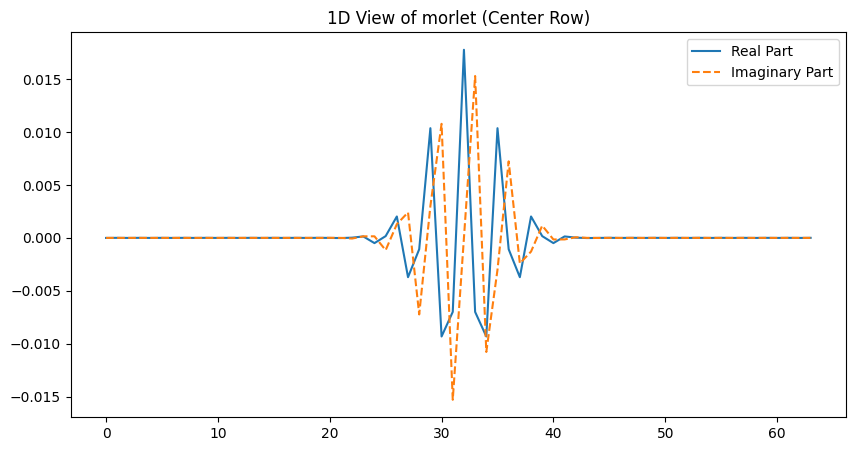

In [9]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Define a small image for testing
Y = np.zeros((64, 64))
Y[32, 32] = 1
Y_mat = matlab.double(Y.tolist())

# Define the wavelet name and parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]  # must be float values
# omega0 controls the number of oscillations (peaks)
# sigma controls the width of the Gaussian envelope, making the peaks sharper or broader
# epsilon adjusts the phase or balance between real and imaginary parts (less frequently adjusted)


scales = matlab.double([1.0])  # Example scale
angles = matlab.double([0.0])  # Example angle

# Create the wavelet structure
wavelet_struct = {'name': wavelet_name, 'param': params}

# Apply 2-D CWT using the selected wavelet
cwt_result = eng.cwtft2(Y_mat, 'wavelet', wavelet_struct, 'scales', scales, 'angles', angles)

# Convert the result to numpy array
cfs = np.array(cwt_result['cfs'])

# Extract the real and imaginary parts of the wavelet in 2D
real_part = np.real(cfs)
imaginary_part = np.imag(cfs)

# 2D Plot of the wavelet
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(real_part.squeeze(), cmap='seismic')
axs[0].set_title(f'Real Part of {wavelet_name}')

axs[1].imshow(imaginary_part.squeeze(), cmap='seismic')
axs[1].set_title(f'Imaginary Part of {wavelet_name}')

# plt.colorbar(axs[0].imshow(real_part.squeeze(), cmap='seismic'), ax=axs[0])
# plt.colorbar(axs[1].imshow(imaginary_part.squeeze(), cmap='seismic'), ax=axs[1])
plt.show()

# 1D Plot (for center row)
fig, ax = plt.subplots(figsize=(10, 5))

center_row = real_part.shape[0] // 2
ax.plot(real_part[center_row, :].squeeze(), label='Real Part')
ax.plot(imaginary_part[center_row, :].squeeze(), label='Imaginary Part', linestyle='--')

ax.set_title(f'1D View of {wavelet_name} (Center Row)')
ax.legend()
plt.show()

# Stop MATLAB engine
eng.quit()

##### Generate all the scales and according wavelengths based on the formula 

The Fourier wavelength for the Morlet wavelet is given by:

$$
\lambda = \frac{4\pi s}{\omega_0 + \sqrt{2 + \omega_0^2}}
$$

Where:
- $ s $ is the scale parameter.
- $\omega_0 $ is the central frequency of the Morlet wavelet.



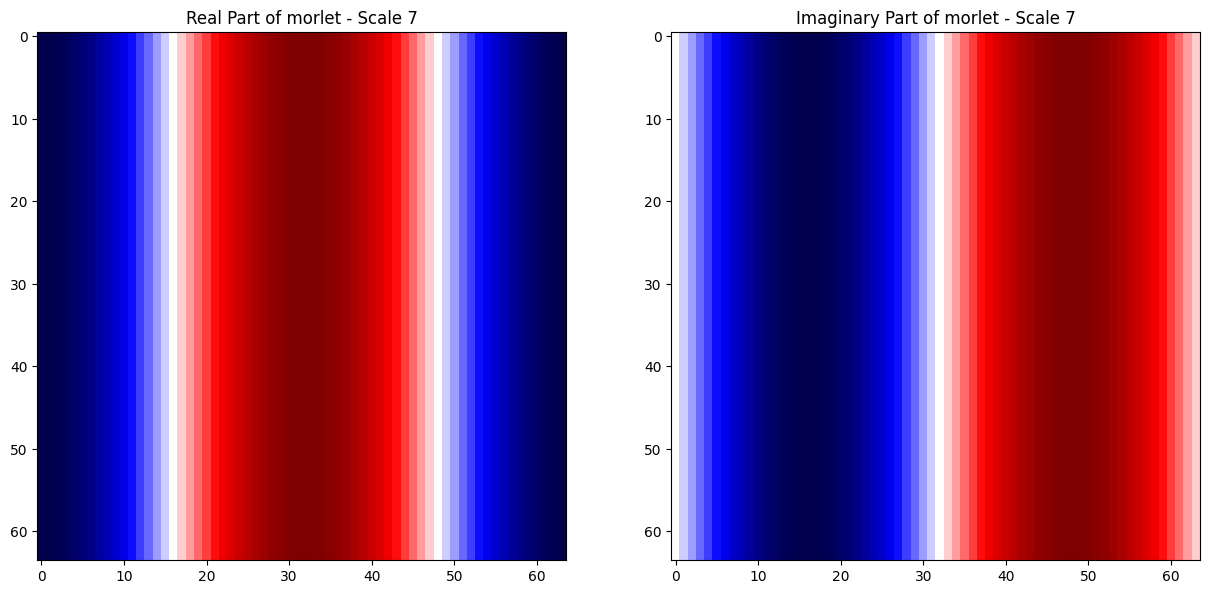

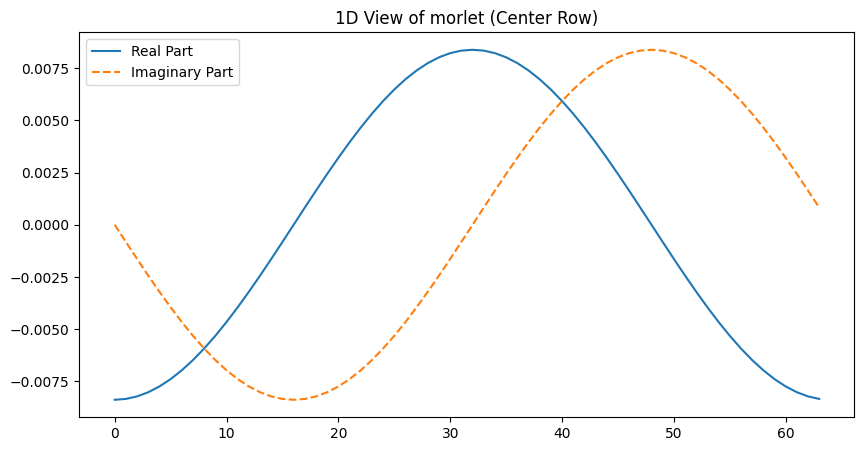

Scale: 1.00, Wavelength (pixels): 2.82 pixels, Wavelength: 2.82 km
Scale: 6.56, Wavelength (pixels): 18.51 pixels, Wavelength: 18.51 km
Scale: 12.11, Wavelength (pixels): 34.20 pixels, Wavelength: 34.20 km
Scale: 17.67, Wavelength (pixels): 49.89 pixels, Wavelength: 49.89 km
Scale: 23.22, Wavelength (pixels): 65.58 pixels, Wavelength: 65.58 km
Scale: 28.78, Wavelength (pixels): 81.27 pixels, Wavelength: 81.27 km
Scale: 34.33, Wavelength (pixels): 96.97 pixels, Wavelength: 96.97 km
Scale: 39.89, Wavelength (pixels): 112.66 pixels, Wavelength: 112.66 km
Scale: 45.44, Wavelength (pixels): 128.35 pixels, Wavelength: 128.35 km
Scale: 51.00, Wavelength (pixels): 144.04 pixels, Wavelength: 144.04 km


In [16]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Define a small image for testing
Y = np.zeros((64, 64))
Y[32, 32] = 1
Y_mat = matlab.double(Y.tolist())

# Define the wavelet name and parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]  # omega0 = 2.5, sigma = 3.0, epsilon = 1.0
# omega0 controls the number of oscillations (peaks)
# sigma controls the width of the Gaussian envelope, making the peaks sharper or broader
# epsilon adjusts the phase or balance between real and imaginary parts (less frequently adjusted)

# Load your image
image = np.flipud(grid[::2,::2,0][:512,:512])  # Modify as needed
image_mat = matlab.double(image.tolist())

# Define scales and angles for the wavelet transform
max_scale = min(image.shape) // 10
scales = np.linspace(1, max_scale, 10) 
omega0 = params[0]

# Convert scale to wavelength in pixel units
wavelengths = (4 * np.pi * scales) / (omega0 + np.sqrt(2 + omega0**2))
wavelengths_km = wavelengths   # Convert to kilometers (not divided by 2 here because the image is already downsampled)

# Apply the conversion for each scale
scales_matlab = matlab.double(scales.tolist())
angles = matlab.double([0.0])  # Example angle

# Create the wavelet structure
wavelet_struct = {'name': wavelet_name, 'param': params}

# Apply 2-D CWT using the selected wavelet
cwt_result = eng.cwtft2(Y_mat, 'wavelet', wavelet_struct, 'scales', scales_matlab, 'angles', angles)

# Convert the result to numpy array
cfs = np.array(cwt_result['cfs'])

# Select a single scale for visualization
selected_scale_index = 6 # zero-indexed, so 4 corresponds to the 5th scale
real_part = np.real(cfs[:, :, 0, selected_scale_index])
imaginary_part = np.imag(cfs[:, :, 0, selected_scale_index])

# 2D Plot of the wavelet
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(real_part.squeeze(), cmap='seismic')
axs[0].set_title(f'Real Part of {wavelet_name} - Scale {selected_scale_index + 1}')

axs[1].imshow(imaginary_part.squeeze(), cmap='seismic')
axs[1].set_title(f'Imaginary Part of {wavelet_name} - Scale {selected_scale_index + 1}')

plt.show()

# 1D Plot (for center row)
fig, ax = plt.subplots(figsize=(10, 5))

center_row = real_part.shape[0] // 2
ax.plot(real_part[center_row, :].squeeze(), label='Real Part')
ax.plot(imaginary_part[center_row, :].squeeze(), label='Imaginary Part', linestyle='--')

ax.set_title(f'1D View of {wavelet_name} (Center Row)')
ax.legend()
plt.show()

# Stop MATLAB engine
eng.quit()

# Print wavelengths corresponding to scales
for i, scale in enumerate(scales):
    print(f'Scale: {scale:.2f}, Wavelength (pixels): {wavelengths[i]:.2f} pixels, Wavelength: {wavelengths_km[i]:.2f} km')


### First try at getting a power spectrum 

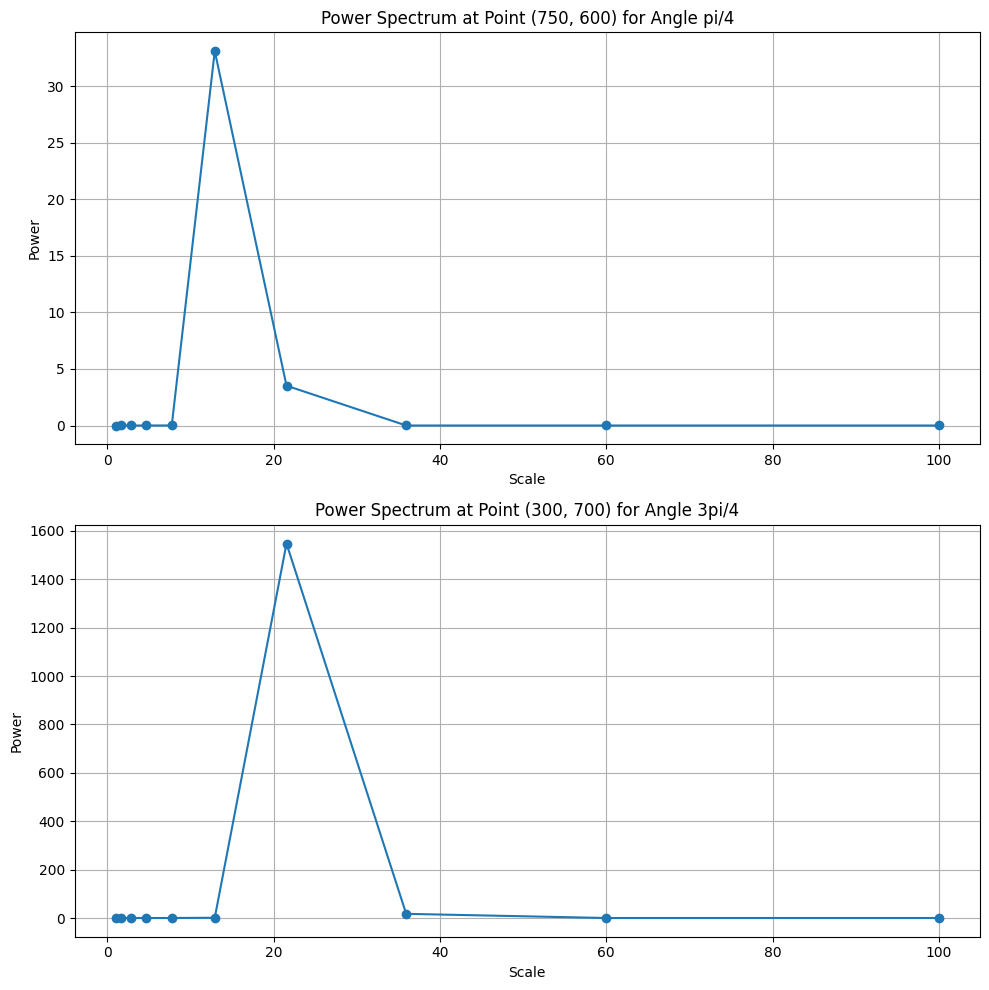

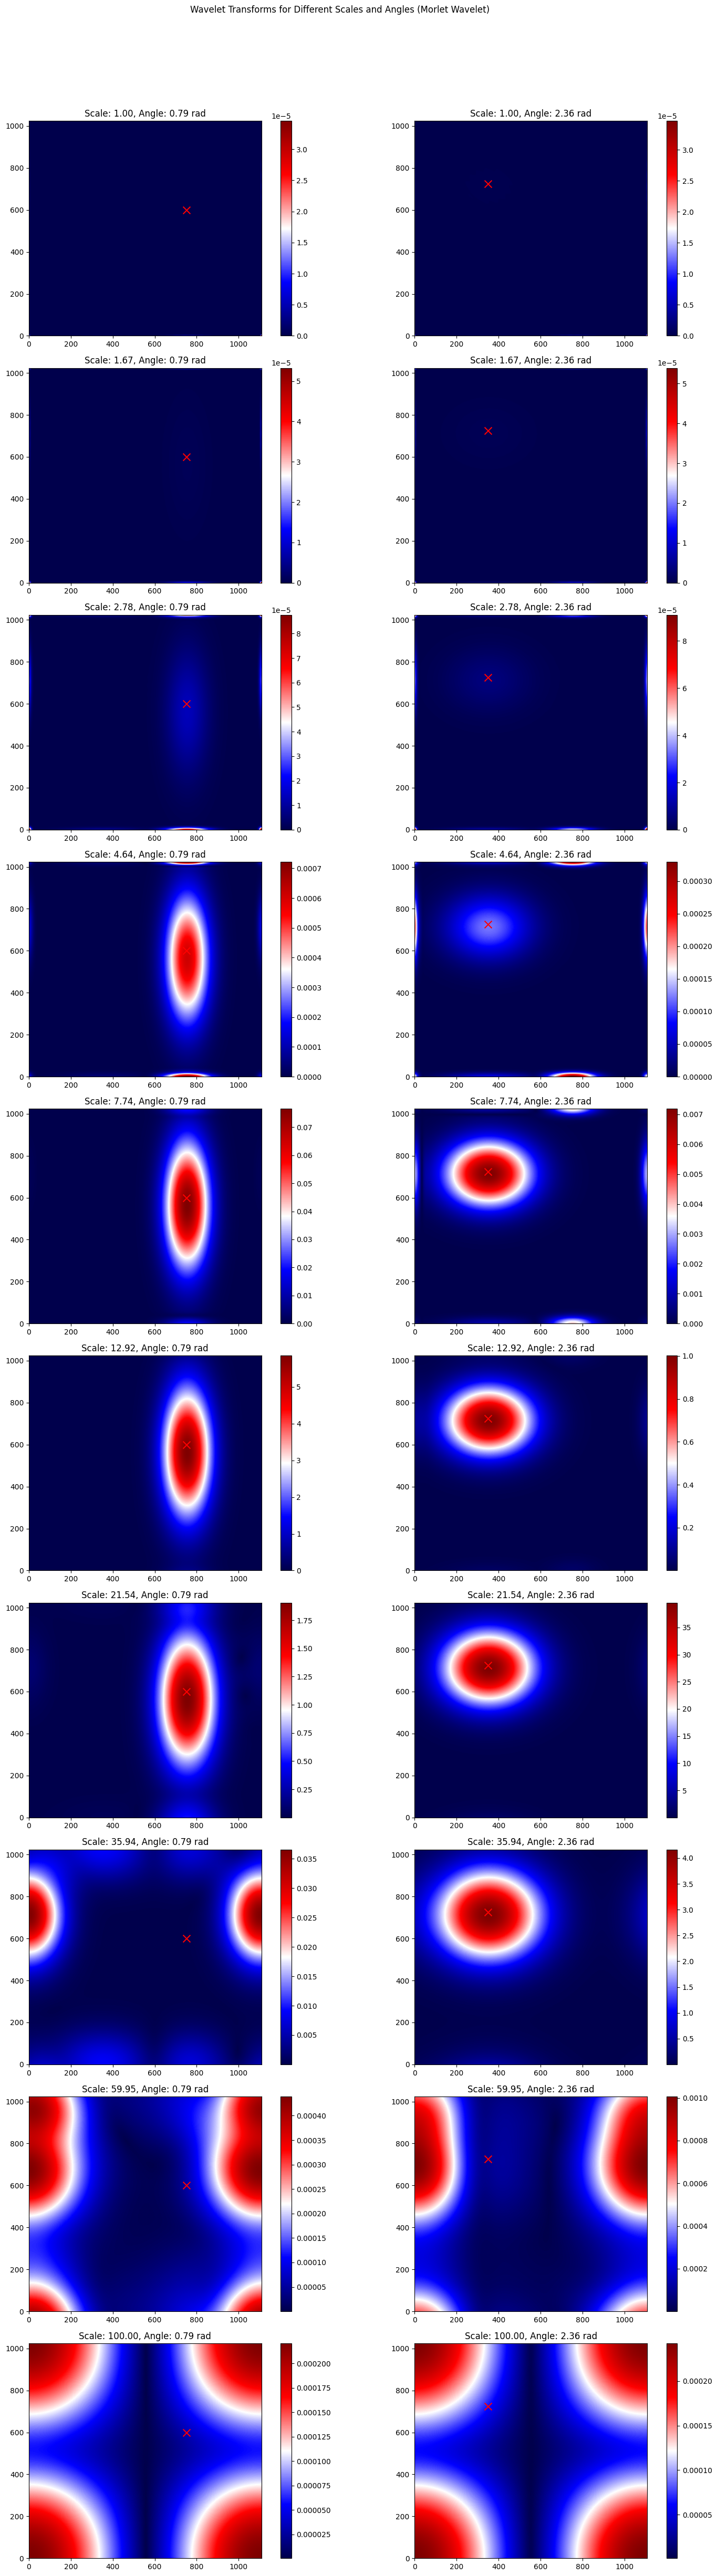

In [51]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Load your image

# image = np.flipud(grid[::2, ::2, 0][:512, :512])  

image = dy+dy2
# image_mat = np.flipud(image[::2,::2][:512,:512])  

image_mat = matlab.double(image.tolist())

# Define wavelet name and parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]  # omega0, sigma, epsilon

# Define non-linear scales for the wavelet transform using a geometric progression
min_scale = 1  # Smallest scale
max_scale = 100  # Largest scale
n_scales = 10  # Number of scales
scales = np.geomspace(min_scale, max_scale, n_scales)

# Convert scale to wavelength in pixel units
omega0 = params[0]
wavelengths = (4 * np.pi * scales) / (omega0 + np.sqrt(2 + omega0**2))
wavelengths_km = wavelengths * 2  # Convert to kilometers

# Angles to examine (e.g., pi/4 and 3pi/4)
angles = np.array([np.pi/4, 3*np.pi/4])

# Convert scales and angles to MATLAB format
scales_matlab = matlab.double(scales.tolist())
angles_matlab = matlab.double(angles.tolist())

# Create the wavelet structure
wavelet_struct = {'name': wavelet_name, 'param': params}

# Apply 2-D CWT using Morlet wavelet
cwt_result = eng.cwtft2(image_mat, 'wavelet', wavelet_struct, 'scales', scales_matlab, 'angles', angles_matlab)
cfs = np.array(cwt_result['cfs'])

# Define points of interest for each angle
points = [(750, 600), (350, 725)]  # (x, y) coordinates

# Initialize lists to store power values for each point
power_values_angle1 = []
power_values_angle2 = []

# Extract power values at specific points for each scale
for i, scale in enumerate(scales):
    power_angle1 = np.abs(cfs[points[0][1], points[0][0], 0, i, 0])**2  # Point for pi/4
    power_angle2 = np.abs(cfs[points[1][1], points[1][0], 0, i, 1])**2  # Point for 3pi/4
    power_values_angle1.append(power_angle1)
    power_values_angle2.append(power_angle2)

# Plot the power values for each point as a function of scale
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Power for angle pi/4
axs[0].plot(scales, power_values_angle1, marker='o')
axs[0].set_title(f'Power Spectrum at Point (750, 600) for Angle pi/4')
axs[0].set_xlabel('Scale')
axs[0].set_ylabel('Power')
axs[0].grid(True)

# Power for angle 3pi/4
axs[1].plot(scales, power_values_angle2, marker='o')
axs[1].set_title(f'Power Spectrum at Point (300, 700) for Angle 3pi/4')
axs[1].set_xlabel('Scale')
axs[1].set_ylabel('Power')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Plot all the transforms on one big subplot grid with cross at selected points
fig, axs = plt.subplots(len(scales), len(angles), figsize=(15, len(scales) * 5))
fig.suptitle(f'Wavelet Transforms for Different Scales and Angles ({wavelet_name.capitalize()} Wavelet)')

# Plot each combination of scale and angle with crosses at points of interest
for i, scale in enumerate(scales):
    for j, angle in enumerate(angles):
        ax = axs[i, j]
        cfs_magnitude = np.abs(cfs[:, :, 0, i, j])
        im = ax.imshow(cfs_magnitude, extent=[0, image.shape[1], 0, image.shape[0]], origin='lower', cmap='seismic')
        ax.scatter(points[j][0], points[j][1], c='red', marker='x', s=100)  # Add cross at point of interest
        ax.set_title(f'Scale: {scale:.2f}, Angle: {angle:.2f} rad')
        fig.colorbar(im, ax=ax)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Stop MATLAB engine
eng.quit()

### Power spectrum + Dynamic scale meshing + dominant wavelength

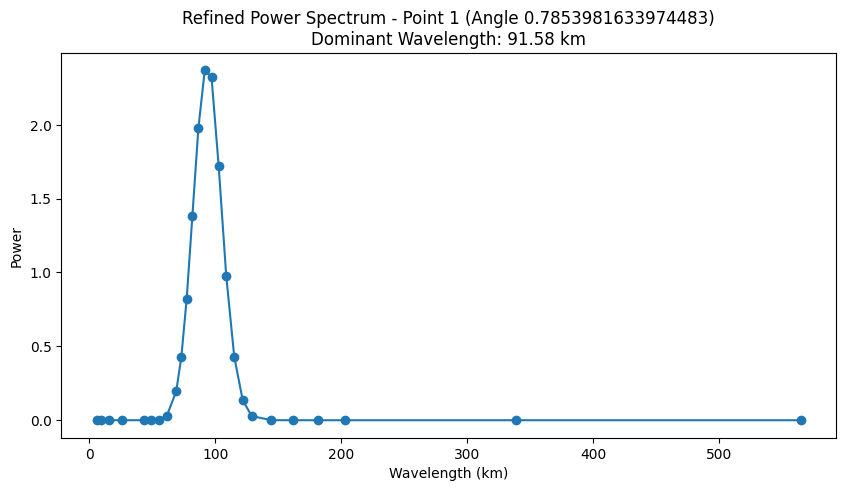

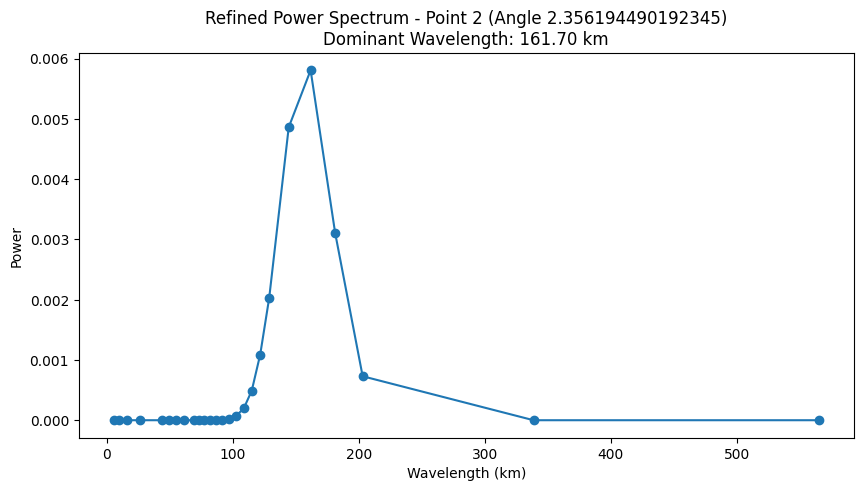

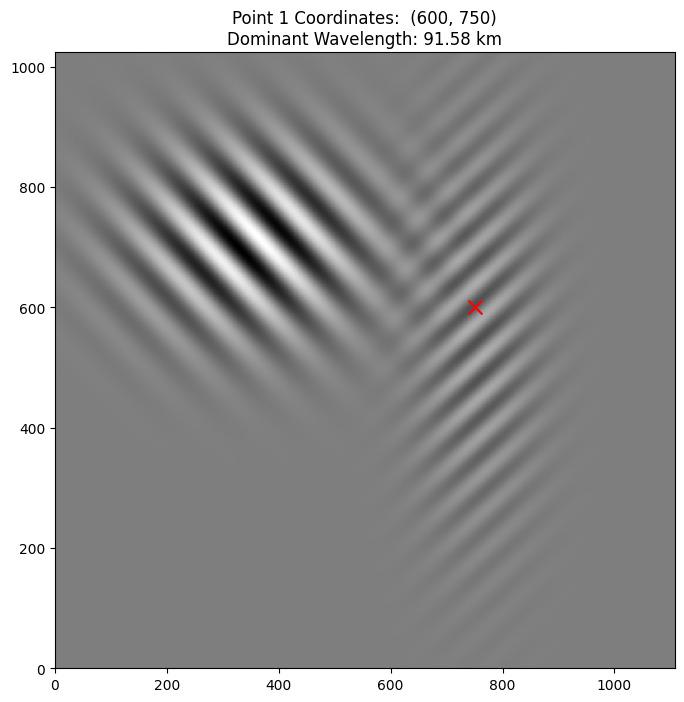

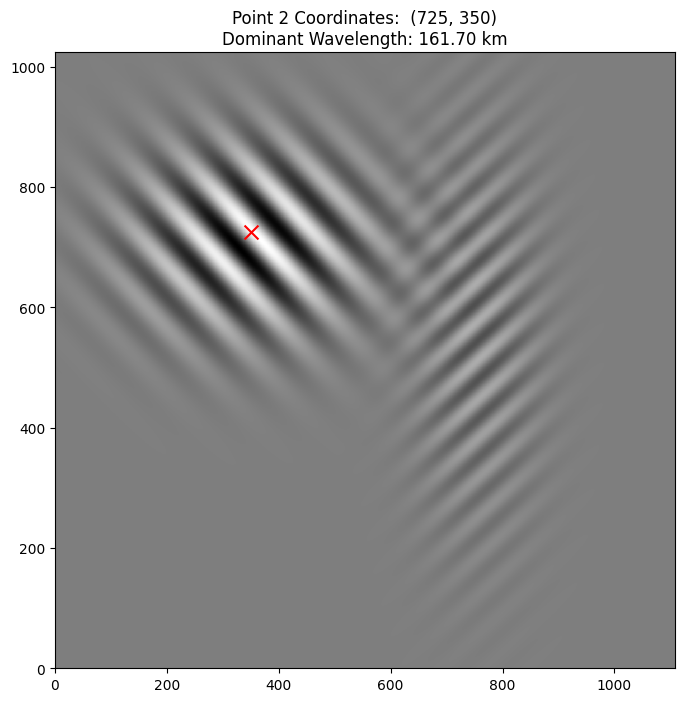

In [13]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Load your image
image = dy + dy2  # Combining dy and dy2
image_mat = matlab.double(image.tolist())

# Wavelet parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]  # omega0, sigma, epsilon
wavelet_struct = {'name': wavelet_name, 'param': params}
angles = [np.pi/4, 3*np.pi/4]

# Points of interest
points = [(600, 750), (725, 350)]

# Initial scan
initial_scales = np.geomspace(1, 100, 10)
scales_matlab = matlab.double(initial_scales.tolist())
angles_matlab = matlab.double(angles)

# Perform initial CWT
cwt_result = eng.cwtft2(image_mat, 'wavelet', wavelet_struct, 'scales', scales_matlab, 'angles', angles_matlab)
cfs = np.array(cwt_result['cfs'])

# Convert scales to wavelengths using the Torrence and Compo formula
omega0 = params[0]
wavelengths = (4 * np.pi * initial_scales) / (omega0 + np.sqrt(2 + omega0**2))
wavelengths_km = wavelengths * 2  # Convert to kilometers

# Analyze initial results
refined_scales = list(initial_scales)
refined_wavelengths_km = list(wavelengths_km)
for idx, (x, y) in enumerate(points):
    power_spectrum = np.abs(cfs[y, x, 0, :, idx]) ** 2
    max_power_idx = np.argmax(power_spectrum)
    
    # Identify the left and right neighbors
    if max_power_idx > 0:
        left_scale = refined_scales[max_power_idx - 1]
        left_wavelength_km = refined_wavelengths_km[max_power_idx - 1]
    else:
        left_scale = refined_scales[max_power_idx]
        left_wavelength_km = refined_wavelengths_km[max_power_idx]
    
    if max_power_idx < len(refined_scales) - 1:
        right_scale = refined_scales[max_power_idx + 1]
        right_wavelength_km = refined_wavelengths_km[max_power_idx + 1]
    else:
        right_scale = refined_scales[max_power_idx]
        right_wavelength_km = refined_wavelengths_km[max_power_idx]
    
    # Refine between the max and its neighbors
    new_scales = np.geomspace(left_scale, right_scale, 10)
    new_wavelengths_km = (4 * np.pi * new_scales) / (omega0 + np.sqrt(2 + omega0**2)) * 2  # Convert to kilometers
    refined_scales += list(new_scales)
    refined_wavelengths_km += list(new_wavelengths_km)

# Sort and remove duplicates
refined_scales, refined_wavelengths_km = zip(*sorted(set(zip(refined_scales, refined_wavelengths_km))))
scales_matlab_refined = matlab.double(refined_scales)

# Perform refined CWT
cwt_result_refined = eng.cwtft2(image_mat, 'wavelet', wavelet_struct, 'scales', scales_matlab_refined, 'angles', angles_matlab)
cfs_refined = np.array(cwt_result_refined['cfs'])

# Visualization for each point
for idx, (x, y) in enumerate(points):
    power_spectrum_refined = np.abs(cfs_refined[y, x, 0, :, idx]) ** 2
    max_power_idx_refined = np.argmax(power_spectrum_refined)
    dominant_wavelength_km = refined_wavelengths_km[max_power_idx_refined]
    
    plt.figure(figsize=(10, 5))
    plt.plot(refined_wavelengths_km, power_spectrum_refined, label=f'Point {idx+1} ({x},{y})')
    plt.scatter(refined_wavelengths_km, power_spectrum_refined)
    plt.xlabel("Wavelength (km)")
    plt.ylabel("Power")
    plt.title(f"Refined Power Spectrum - Point {idx+1} (Angle {angles[idx]})\nDominant Wavelength: {dominant_wavelength_km:.2f} km")
    plt.show()

# Display points on the image with dominant wavelength
for idx, (x, y) in enumerate(points):
    max_power_idx_refined = np.argmax(np.abs(cfs_refined[y, x, 0, :, idx]) ** 2)
    dominant_wavelength_km = refined_wavelengths_km[max_power_idx_refined]
    
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(image, cmap='gray')
    plt.scatter([y], [x], c='red', s=100, marker='x')
    plt.title(f"Point {idx+1} Coordinates:  ({x}, {y})\nDominant Wavelength: {dominant_wavelength_km:.2f} km")
    plt.show()

# End MATLAB session
eng.quit()


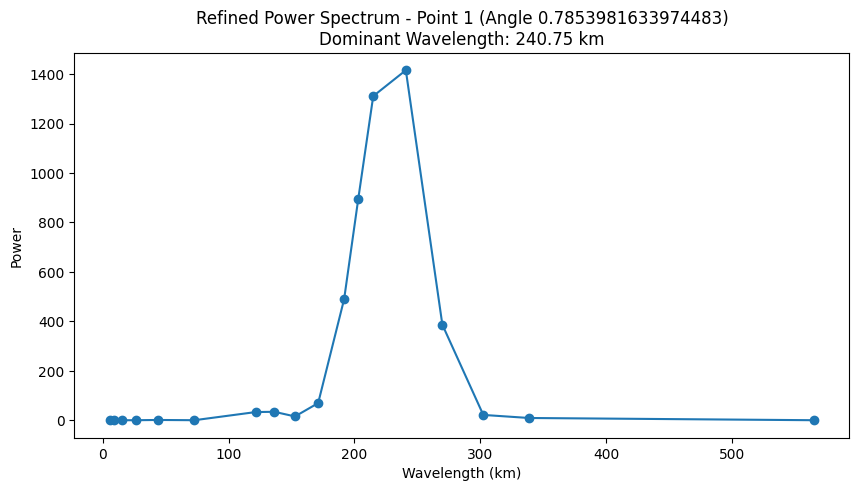

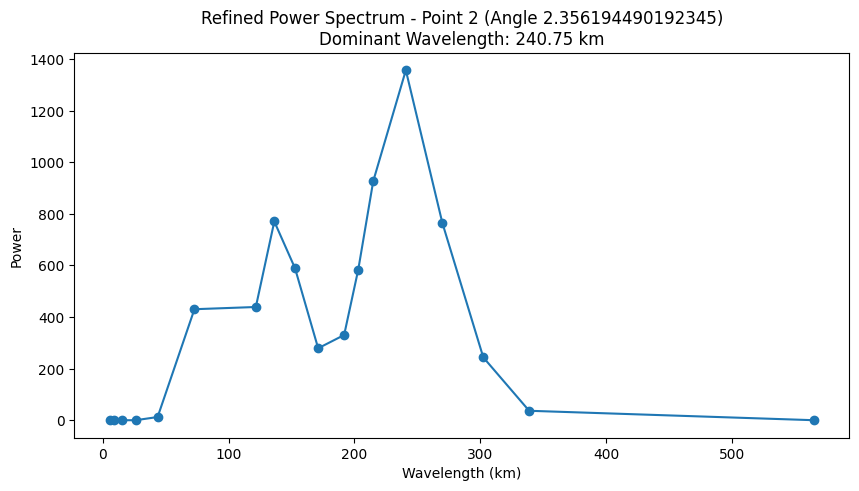

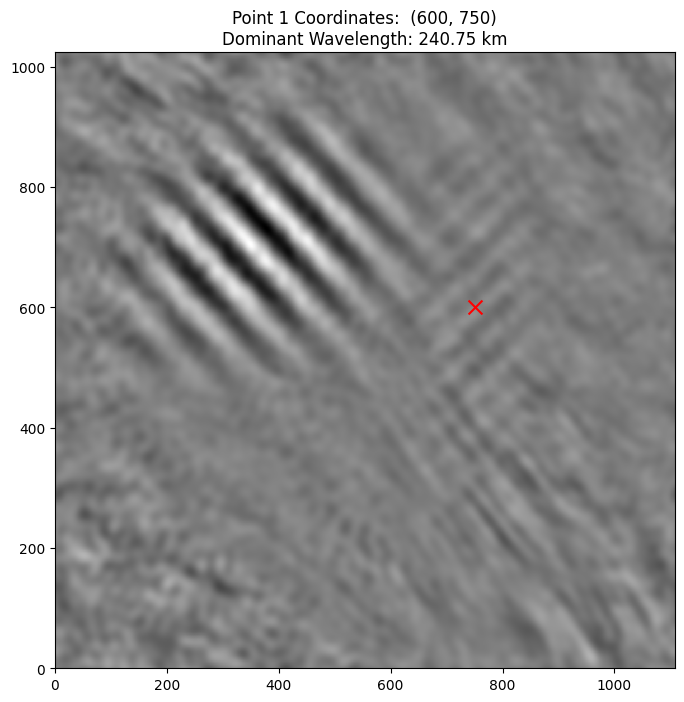

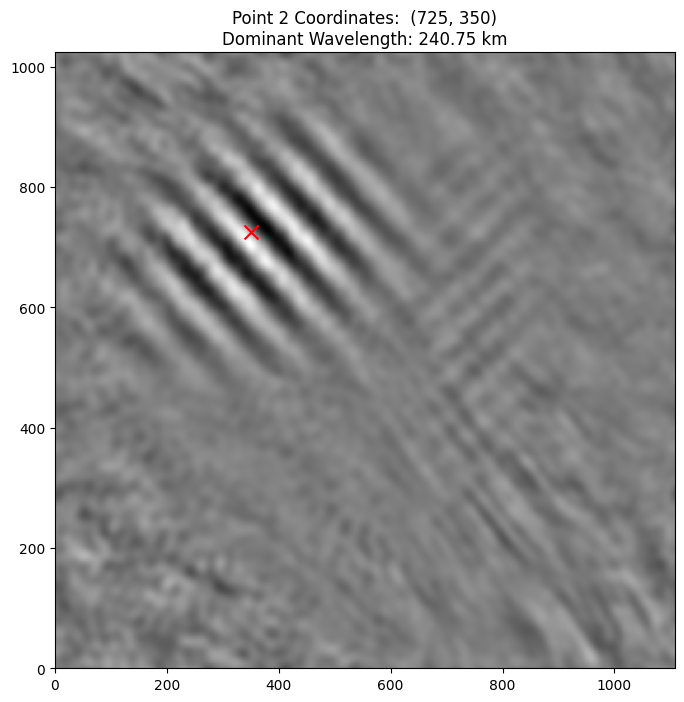

In [17]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
from Eof_functions import filter_frames

# Start MATLAB engine
eng = matlab.engine.start_matlab()

kl_inf = 0.00666666666 # 300 Km
kl_sup = 0.06666666666 # 30 Km
cf_inf = 12 
c_sup = 17 

# Filter the frames based on the same parameters
frames_disp = filter_frames(grid, kl_inf, kl_sup, cf_inf, c_sup)

# Load your image
image = frames_disp[:,:,0]
# Load your image
# image = np.flipud(image[::2,::2][:512,:512])  # Modify as needed

image_mat = matlab.double(image.tolist())

# Wavelet parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]  # omega0, sigma, epsilon
wavelet_struct = {'name': wavelet_name, 'param': params}
angles = [np.pi/4, 3*np.pi/4]

# Points of interest
points = [(600, 750), (725, 350)]

# Initial scan
initial_scales = np.geomspace(1, 100, 10)
scales_matlab = matlab.double(initial_scales.tolist())
angles_matlab = matlab.double(angles)

# Perform initial CWT
cwt_result = eng.cwtft2(image_mat, 'wavelet', wavelet_struct, 'scales', scales_matlab, 'angles', angles_matlab)
cfs = np.array(cwt_result['cfs'])

# Convert scales to wavelengths using the Torrence and Compo formula
omega0 = params[0]
wavelengths = (4 * np.pi * initial_scales) / (omega0 + np.sqrt(2 + omega0**2))
wavelengths_km = wavelengths * 2  # Convert to kilometers

# Analyze initial results
refined_scales = list(initial_scales)
refined_wavelengths_km = list(wavelengths_km)
for idx, (x, y) in enumerate(points):
    power_spectrum = np.abs(cfs[y, x, 0, :, idx]) ** 2
    max_power_idx = np.argmax(power_spectrum)
    
    # Identify the left and right neighbors
    if max_power_idx > 0:
        left_scale = refined_scales[max_power_idx - 1]
        left_wavelength_km = refined_wavelengths_km[max_power_idx - 1]
    else:
        left_scale = refined_scales[max_power_idx]
        left_wavelength_km = refined_wavelengths_km[max_power_idx]
    
    if max_power_idx < len(refined_scales) - 1:
        right_scale = refined_scales[max_power_idx + 1]
        right_wavelength_km = refined_wavelengths_km[max_power_idx + 1]
    else:
        right_scale = refined_scales[max_power_idx]
        right_wavelength_km = refined_wavelengths_km[max_power_idx]
    
    # Refine between the max and its neighbors
    new_scales = np.geomspace(left_scale, right_scale, 10)
    new_wavelengths_km = (4 * np.pi * new_scales) / (omega0 + np.sqrt(2 + omega0**2)) * 2  # Convert to kilometers
    refined_scales += list(new_scales)
    refined_wavelengths_km += list(new_wavelengths_km)

# Sort and remove duplicates
refined_scales, refined_wavelengths_km = zip(*sorted(set(zip(refined_scales, refined_wavelengths_km))))
scales_matlab_refined = matlab.double(refined_scales)

# Perform refined CWT
cwt_result_refined = eng.cwtft2(image_mat, 'wavelet', wavelet_struct, 'scales', scales_matlab_refined, 'angles', angles_matlab)
cfs_refined = np.array(cwt_result_refined['cfs'])

# Visualization for each point
for idx, (x, y) in enumerate(points):
    power_spectrum_refined = np.abs(cfs_refined[y, x, 0, :, idx]) ** 2
    max_power_idx_refined = np.argmax(power_spectrum_refined)
    dominant_wavelength_km = refined_wavelengths_km[max_power_idx_refined]
    
    plt.figure(figsize=(10, 5))
    plt.plot(refined_wavelengths_km, power_spectrum_refined, label=f'Point {idx+1} ({x},{y})')
    plt.scatter(refined_wavelengths_km, power_spectrum_refined)
    plt.xlabel("Wavelength (km)")
    plt.ylabel("Power")
    plt.title(f"Refined Power Spectrum - Point {idx+1} (Angle {angles[idx]})\nDominant Wavelength: {dominant_wavelength_km:.2f} km")
    plt.show()

# Display points on the image with dominant wavelength
for idx, (x, y) in enumerate(points):
    max_power_idx_refined = np.argmax(np.abs(cfs_refined[y, x, 0, :, idx]) ** 2)
    dominant_wavelength_km = refined_wavelengths_km[max_power_idx_refined]
    
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(image, cmap='gray')
    plt.scatter([y], [x], c='red', s=100, marker='x')
    plt.title(f"Point {idx+1} Coordinates:  ({x}, {y})\nDominant Wavelength: {dominant_wavelength_km:.2f} km")
    plt.show()

# End MATLAB session
eng.quit()


## Trying out the anisotropical properties of the morlet wavelet

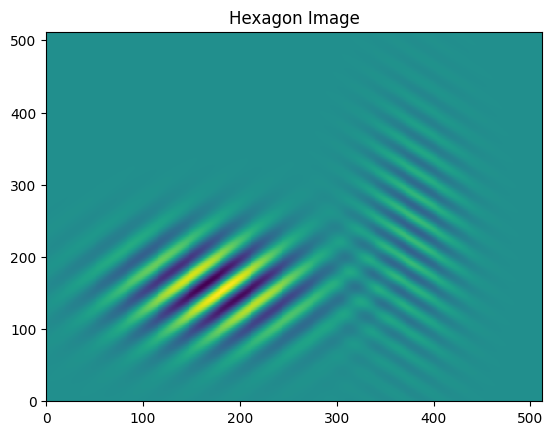

Shape of cwtCauchy['cfs']: (512, 512, 1, 3, 16)
Shape of cwtMarr['cfs']: (512, 512, 1, 3, 16)


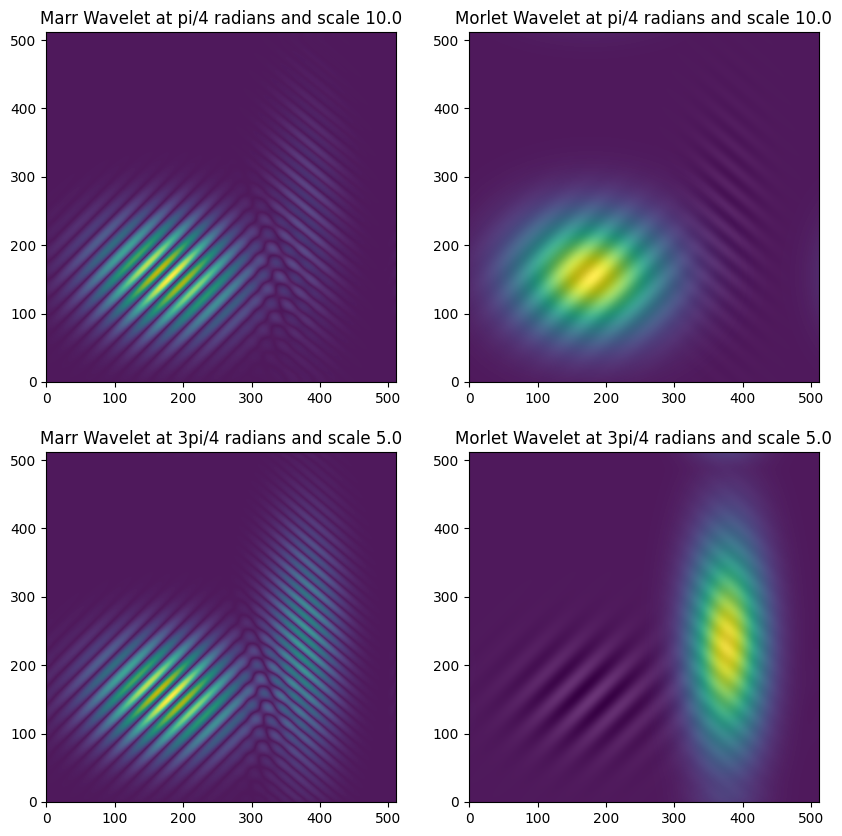

In [12]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Load and view the hexagon image
# img = plt.imread("TestFile.jpg")
# img = (img * 255).astype(np.uint8)  # Convert to unsigned integer
# img_mat = matlab.uint8(img.tolist())

img = dy+dy2
# Load your image
img = np.flipud(img[::2,::2][:512,:512])  # Modify as needed
img_mat = matlab.double(img.tolist())

plt.pcolormesh(img)
plt.title('Hexagon Image')
plt.show()

# Obtain 2-D CWT of the hexagon image using Marr and Cauchy wavelets
cwtScales = matlab.double([5, 10, 20])
cwtAngles = matlab.double(list(np.arange(0, 2 * np.pi, np.pi / 8)))

# Define wavelet name and parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]  # omega0, sigma, epsilon
wavelet_struct = {'name': wavelet_name, 'param': params}
cwtCauchy = eng.cwtft2(img_mat, 'wavelet', wavelet_struct, 'scales', cwtScales, 'angles', cwtAngles)


cwtMarr = eng.cwtft2(img_mat, 'wavelet', 'marr', 'scales', cwtScales, 'angles', cwtAngles)

print(f"Shape of cwtCauchy['cfs']: {np.array(cwtCauchy['cfs']).shape}")
print(f"Shape of cwtMarr['cfs']: {np.array(cwtMarr['cfs']).shape}")
cfs_cauchy = np.array(cwtCauchy['cfs'])
cfs_marr = np.array(cwtMarr['cfs'])

angz = ["0", "pi/8", "pi/4", "3pi/8", "pi/2", "5pi/8", "3pi/4", "7pi/8", 
    "pi", "9pi/8", "5pi/4", "11pi/8", "3pi/2", "13pi/8", "7pi/4", "15pi/8"]

indexAngle1 = 2  # pi/4
indexAngle2 = 6  # 3pi/4

indexScale1 = 1  # 10
indexScale2 = 0  # 5

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Zip the angle indices and scale indices together
for i, (k, l) in enumerate(zip([indexAngle1, indexAngle2], [indexScale1, indexScale2])):
    axs[i, 0].imshow(np.abs(cfs_marr[:, :, 0, l, k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i, 0].imshow(img, origin='lower', alpha=0.2, cmap='gray')
    axs[i, 0].set_title(f'Marr Wavelet at {angz[k]} radians and scale {cwtScales[0][l]}')
    
    axs[i, 1].imshow(np.abs(cfs_cauchy[:, :, 0, l, k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i, 1].imshow(img, origin='lower', alpha=0.2, cmap='gray')
    axs[i, 1].set_title(f'Morlet Wavelet at {angz[k]} radians and scale {cwtScales[0][l]}')

plt.show()

# Stop MATLAB engine
eng.quit()

TargetMatrix1= cfs_cauchy[:, :, 0, indexScale1, indexAngle1]
TargetMatrix2= cfs_cauchy[:, :, 0, indexScale2, indexAngle2]


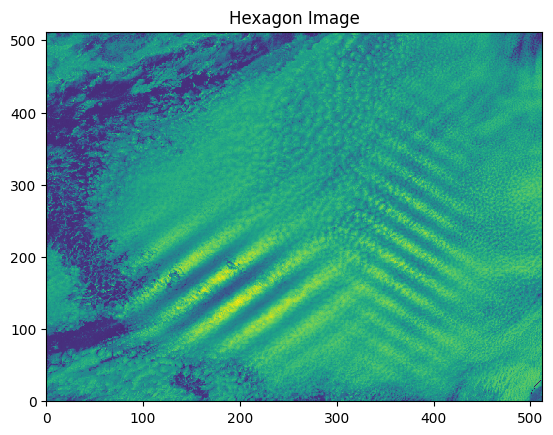

Shape of cwtCauchy['cfs']: (512, 512, 1, 8, 16)
Shape of cwtMarr['cfs']: (512, 512, 1, 8, 16)


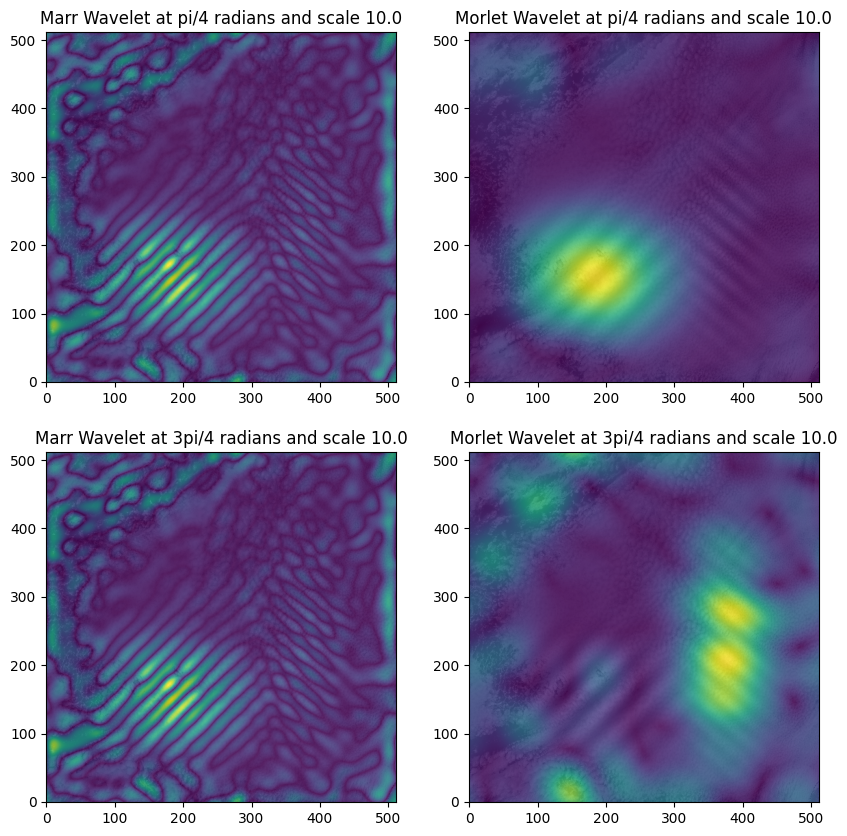

In [13]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Load and view the hexagon image
# img = plt.imread("TestFile.jpg")
# img = (img * 255).astype(np.uint8)  # Convert to unsigned integer
# img_mat = matlab.uint8(img.tolist())

img = grid[:,:,0]
# Load your image
img = np.flipud(img[::2,::2][:512,:512])  # Modify as needed

img_mat = matlab.double(img.tolist())

plt.pcolormesh(img)
plt.title('Hexagon Image')
plt.show()

# Obtain 2-D CWT of the hexagon image using Marr and Cauchy wavelets
cwtScales = matlab.double([5, 10, 20, 40, 60, 80, 100, 120])
cwtAngles = matlab.double(list(np.arange(0, 2 * np.pi, np.pi / 8)))

# Define wavelet name and parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]  # omega0, sigma, epsilon
wavelet_struct = {'name': wavelet_name, 'param': params}
cwtCauchy = eng.cwtft2(img_mat, 'wavelet', wavelet_struct, 'scales', cwtScales, 'angles', cwtAngles)


cwtMarr = eng.cwtft2(img_mat, 'wavelet', 'marr', 'scales', cwtScales, 'angles', cwtAngles)

print(f"Shape of cwtCauchy['cfs']: {np.array(cwtCauchy['cfs']).shape}")
print(f"Shape of cwtMarr['cfs']: {np.array(cwtMarr['cfs']).shape}")
cfs_cauchy = np.array(cwtCauchy['cfs'])
cfs_marr = np.array(cwtMarr['cfs'])

angz = ["0", "pi/8", "pi/4", "3pi/8", "pi/2", "5pi/8", "3pi/4", "7pi/8", 
    "pi", "9pi/8", "5pi/4", "11pi/8", "3pi/2", "13pi/8", "7pi/4", "15pi/8"]

indexAngle1 = 2  # pi/4
indexAngle2 = 6  # 3pi/4

indexScale1 = 1  # 10
indexScale2 = 1  # 5

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Zip the angle indices and scale indices together
for i, (k, l) in enumerate(zip([indexAngle1, indexAngle2], [indexScale1, indexScale2])):
    axs[i, 0].imshow(np.abs(cfs_marr[:, :, 0, l, k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i, 0].imshow(img, origin='lower', alpha=0.2, cmap='gray')
    axs[i, 0].set_title(f'Marr Wavelet at {angz[k]} radians and scale {cwtScales[0][l]}')
    
    axs[i, 1].imshow(np.abs(cfs_cauchy[:, :, 0, l, k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i, 1].imshow(img, origin='lower', alpha=0.2, cmap='gray')
    axs[i, 1].set_title(f'Morlet Wavelet at {angz[k]} radians and scale {cwtScales[0][l]}')

plt.show()

# Stop MATLAB engine
eng.quit()


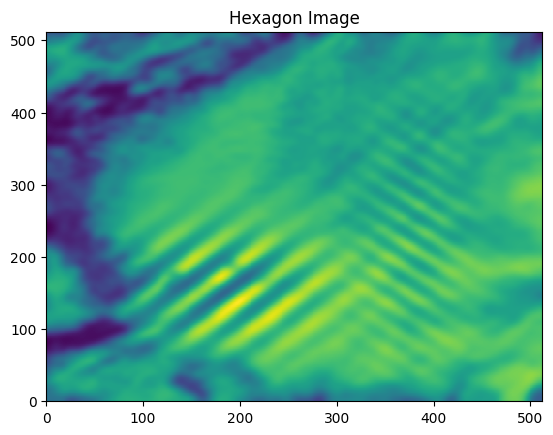

Shape of cwtCauchy['cfs']: (512, 512, 1, 8, 16)
Shape of cwtMarr['cfs']: (512, 512, 1, 8, 16)


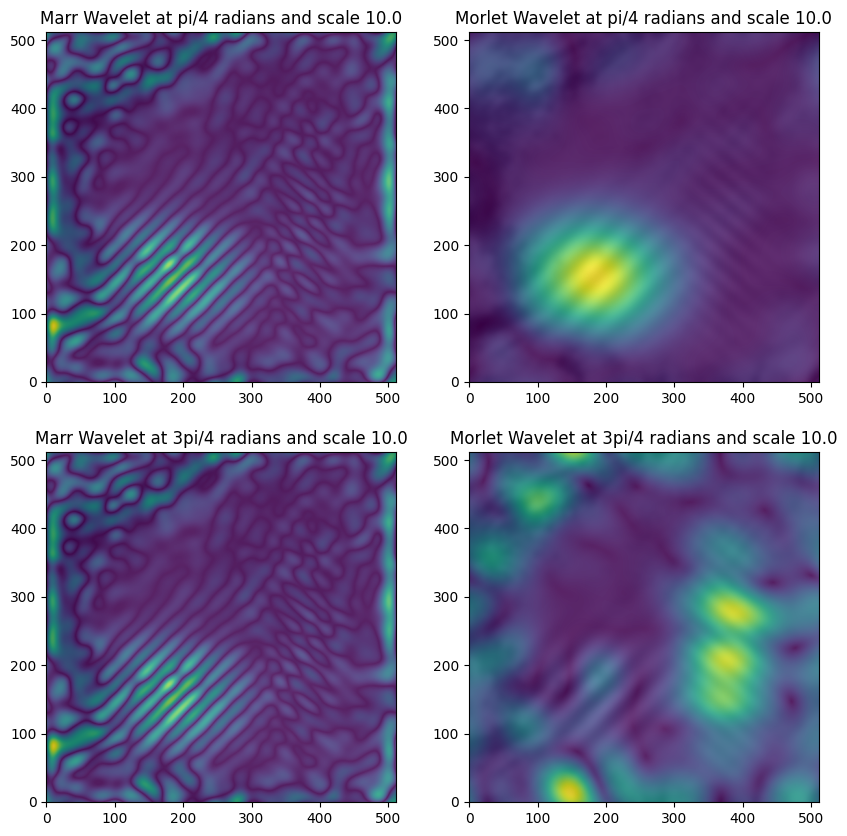

In [14]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Load and view the hexagon image
# img = plt.imread("TestFile.jpg")
# img = (img * 255).astype(np.uint8)  # Convert to unsigned integer
# img_mat = matlab.uint8(img.tolist())

img = grid[:,:,0]
# Load your image
img = np.flipud(img[::2,::2][:512,:512])  # Modify as needed

img = gaussian_filter(img, sigma=5) 

img_mat = matlab.double(img.tolist())

plt.pcolormesh(img)
plt.title('Hexagon Image')
plt.show()

# Obtain 2-D CWT of the hexagon image using Marr and Cauchy wavelets
cwtScales = matlab.double([5, 10, 20, 40, 60, 80, 100, 120])
cwtAngles = matlab.double(list(np.arange(0, 2 * np.pi, np.pi / 8)))

# Define wavelet name and parameters
wavelet_name = 'morlet'
params = [2.0, 3.0, 1.0]  # omega0, sigma, epsilon
wavelet_struct = {'name': wavelet_name, 'param': params}
cwtCauchy = eng.cwtft2(img_mat, 'wavelet', wavelet_struct, 'scales', cwtScales, 'angles', cwtAngles)


cwtMarr = eng.cwtft2(img_mat, 'wavelet', 'marr', 'scales', cwtScales, 'angles', cwtAngles)

print(f"Shape of cwtCauchy['cfs']: {np.array(cwtCauchy['cfs']).shape}")
print(f"Shape of cwtMarr['cfs']: {np.array(cwtMarr['cfs']).shape}")
cfs_cauchy = np.array(cwtCauchy['cfs'])
cfs_marr = np.array(cwtMarr['cfs'])

angz = ["0", "pi/8", "pi/4", "3pi/8", "pi/2", "5pi/8", "3pi/4", "7pi/8", 
    "pi", "9pi/8", "5pi/4", "11pi/8", "3pi/2", "13pi/8", "7pi/4", "15pi/8"]

indexAngle1 = 2  # pi/4
indexAngle2 = 6  # 3pi/4

indexScale1 = 1  # 10
indexScale2 = 1  # 5

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Zip the angle indices and scale indices together
for i, (k, l) in enumerate(zip([indexAngle1, indexAngle2], [indexScale1, indexScale2])):
    axs[i, 0].imshow(np.abs(cfs_marr[:, :, 0, l, k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i, 0].imshow(img, origin='lower', alpha=0.2, cmap='gray')
    axs[i, 0].set_title(f'Marr Wavelet at {angz[k]} radians and scale {cwtScales[0][l]}')
    
    axs[i, 1].imshow(np.abs(cfs_cauchy[:, :, 0, l, k]), extent=[0, img.shape[1], 0, img.shape[0]], origin='lower')
    axs[i, 1].imshow(img, origin='lower', alpha=0.2, cmap='gray')
    axs[i, 1].set_title(f'Morlet Wavelet at {angz[k]} radians and scale {cwtScales[0][l]}')

plt.show()

# Stop MATLAB engine
eng.quit()


## Dominant scale method (Not Working)

In [ ]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Load your image
image = np.flipud(grid[::2,::2,0][:512,:512])  # Modify as needed
image_mat = matlab.double(image.tolist())

# Define scales and angles for the wavelet transform
max_scale = min(image.shape) // 2
scales = np.linspace(1, max_scale, 10)  # 10 scales from 1 to half the image size
angles = np.linspace(0, 2*np.pi, 9)  # 8 angles from 0 to 2π

scales_mat = matlab.double(scales.tolist())
angles_mat = matlab.double(angles.tolist())

# Apply 2-D CWT using Morlet wavelet
cwtmorl = eng.cwtft2(image_mat, 'wavelet', 'morl', 'scales', scales_mat, 'angles', angles_mat)
cfs_morl = np.array(cwtmorl['cfs'])
print(f"Shape of cwtmorl['cfs']: {cfs_morl.shape}")

# Apply 2-D CWT using Cauchy wavelet
cwtcauchy = eng.cwtft2(image_mat, 'wavelet', 'cauchy', 'scales', scales_mat, 'angles', angles_mat)
cfs_cauchy = np.array(cwtcauchy['cfs'])
print(f"Shape of cwtcauchy['cfs']: {cfs_cauchy.shape}")

# Save the data for later use
np.save('cfs_morl.npy', cfs_morl)
np.save('cfs_cauchy.npy', cfs_cauchy)

# Stop MATLAB engine
eng.quit()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example of how to load and visualize data for specific angle and scale
# Load saved data
cfs_morl = np.load('cfs_morl.npy')
cfs_cauchy = np.load('cfs_cauchy.npy')

# Load your image
image = np.flipud(grid[::2,::2,0][:512,:512])  # Modify as needed

# Define scales and angles used in the wavelet transform
max_scale = 256 // 2
scales = np.linspace(1, max_scale, 10)  # 10 scales from 1 to half the image size
angles = np.linspace(0, 360, 9)  # 8 angles from 0 to 360 degrees

# Define a fixed scale to use for visualization
scale_value = scales[2]  # Example fixed scale value
index_scale = np.argmin(np.abs(scales - scale_value))  # Find the closest index for the scale

fig, axs = plt.subplots(len(angles), 2, figsize=(12, len(angles) * 4))

for j, angle_value_degrees in enumerate(angles):
    index_angle = np.argmin(np.abs(angles - angle_value_degrees))  # Find the closest index for the angle

    # Morlet Wavelet
    axs[j, 0].imshow(np.abs(cfs_morl[:,:,0,index_scale,index_angle]), extent=[0, 512, 0, 512], origin='lower')
    axs[j, 0].imshow(image, extent=[0, 512, 0, 512], origin='lower', alpha=0.2, cmap='gray')
    axs[j, 0].set_title(f'Morlet at {angle_value_degrees:.0f}°, Scale {scale_value:.2f}')

    # Cauchy Wavelet
    axs[j, 1].imshow(np.abs(cfs_cauchy[:,:,0,index_scale,index_angle]), extent=[0, 512, 0, 512], origin='lower')
    axs[j, 1].imshow(image, extent=[0, 512, 0, 512], origin='lower', alpha=0.2, cmap='gray')
    axs[j, 1].set_title(f'Cauchy at {angle_value_degrees:.0f}°, Scale {scale_value:.2f}')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = np.flipud(grid[::2,::2,0][:512,:512])  # Modify if necessary

# Load the saved data
cfs_morl = np.load('cfs_morl.npy')
cfs_cauchy = np.load('cfs_cauchy.npy')

# Display the shapes of the matrices for debugging
print(f"Shape of cfs_morl: {cfs_morl.shape}")
print(f"Shape of cfs_cauchy: {cfs_cauchy.shape}")

# Extract the indices of the dominant scales and angles
dominant_scale_index_morl = np.argmax(np.max(cfs_morl, axis=4), axis=3).squeeze()
dominant_angle_index_morl = np.argmax(np.max(cfs_morl, axis=3), axis=3).squeeze()

dominant_scale_index_cauchy = np.argmax(np.max(cfs_cauchy, axis=4), axis=3).squeeze()
dominant_angle_index_cauchy = np.argmax(np.max(cfs_cauchy, axis=3), axis=3).squeeze()

# Define the scales and angles used in the wavelet transform
max_scale = 256 // 2
scales = np.linspace(1, max_scale, 10)  # 10 scales from 1 to half the image size
angles = np.linspace(0, 360, 9)  # 9 angles from 0 to 360 degrees

# Get the actual values of the dominant scales and angles
dominant_scale_morl = scales[dominant_scale_index_morl]
dominant_angle_morl = angles[dominant_angle_index_morl]

dominant_scale_cauchy = scales[dominant_scale_index_cauchy]
dominant_angle_cauchy = angles[dominant_angle_index_cauchy]

# Display the shapes of the matrices for debugging
print(f"Shape of dominant_scale_morl: {dominant_scale_morl.shape}")
print(f"Shape of dominant_angle_morl: {dominant_angle_morl.shape}")
print(f"Shape of dominant_scale_cauchy: {dominant_scale_cauchy.shape}")
print(f"Shape of dominant_angle_cauchy: {dominant_angle_cauchy.shape}")

# Visualize the dominant scales and angles
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Dominant scales for Morlet
im1 = axs[0, 0].imshow(dominant_scale_morl, cmap='jet', extent=[0, 512, 0, 512], origin='lower')
axs[0, 0].imshow(image, extent=[0, 512, 0, 512], origin='lower', alpha=0.3)
axs[0, 0].set_title('Morlet - Dominant Scales')
fig.colorbar(im1, ax=axs[0, 0])

# Dominant angles for Morlet
im2 = axs[0, 1].imshow(dominant_angle_morl, cmap='hsv', extent=[0, 512, 0, 512], origin='lower')
axs[0, 1].imshow(image, extent=[0, 512, 0, 512], origin='lower', alpha=0.3)
axs[0, 1].set_title('Morlet - Dominant Angles')
fig.colorbar(im2, ax=axs[0, 1])

# Dominant scales for Cauchy
im3 = axs[1, 0].imshow(dominant_scale_cauchy, cmap='jet', extent=[0, 512, 0, 512], origin='lower')
axs[1, 0].imshow(image, extent=[0, 512, 0, 512], origin='lower', alpha=0.3)
axs[1, 0].set_title('Cauchy - Dominant Scales')
fig.colorbar(im3, ax=axs[1, 0])

# Dominant angles for Cauchy
im4 = axs[1, 1].imshow(dominant_angle_cauchy, cmap='hsv', extent=[0, 512, 0, 512], origin='lower')
axs[1, 1].imshow(image, extent=[0, 512, 0, 512], origin='lower', alpha=0.3)
axs[1, 1].set_title('Cauchy - Dominant Angles')
fig.colorbar(im4, ax=axs[1, 1])

plt.tight_layout()
plt.show()
